# Lane Filter

In [1]:
import os
os.environ.setdefault("DISABLE_CONTRACTS", "1")

import time
import cv2
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc("figure", dpi=150)

import ipywidgets as widgets
from ipywidgets import interact

from dt_state_estimation.lane_filter import LaneFilterHistogram
from dt_state_estimation.lane_filter.types import Segment, SegmentPoint, SegmentColor

from dt_state_estimation.lane_filter.rendering import plot_belief

In [2]:
# constants
segment_length: float = 0.1
lane_width: float = 0.225
half_lane: float = lane_width * 0.5
distance: float = 0.0

# create filter
filter = LaneFilterHistogram()

def run_filter(lateral_shift: float, rotation: float):
    """
    Args:
        lateral_shift `float`:  A positive number shifts the segments to the robot's right, effectively 
                                pushing the pose towards the left curb.
                                A negative number shifts the segments to the robot's left, effectively 
                                pushing the pose towards the yellow line.
                                
        rotation `float`:       A positive rotation indicates an angle going from the robot's x-axis towards 
                                its y-axis.
                                Positive rotations here simulate left curves, where the white markings appear 
                                in front of the robot, only white segments have a vote in this case.
                                Negative rotations instead simulate right curves, where the yellow markings 
                                appear in front of the robot, only yellow segments have a vote in this case.
    """
    # simple 2D rotation, used to rotate the segments about the robot's origin
    R = np.array([
        [np.cos(rotation), -np.sin(rotation), 0],
        [np.sin(rotation), np.cos(rotation), 0],
        [0, 0, 1]
    ])

    # white segment (controls left curves, which is a positive `rotation` above)
    p0 = np.array([distance, lateral_shift - half_lane, 1])
    p1 = np.array([distance + segment_length, lateral_shift - half_lane, 1])

    # rotate white segment
    p0 = np.dot(R, p0)
    p1 = np.dot(R, p1)

    white_segment = Segment(
        points=[
            SegmentPoint(p0[0], p0[1]),
            SegmentPoint(p1[0], p1[1]),
        ],
        color=SegmentColor.WHITE
    )

    # yellow segment (controls right curves, which is a negative `rotation` above)
    p0 = np.array([distance, lateral_shift + half_lane, 1])
    p1 = np.array([distance + segment_length, lateral_shift + half_lane, 1])

    # rotate yellow segment
    p0 = np.dot(R, p0)
    p1 = np.dot(R, p1)

    yellow_segment = Segment(
        points=[
            SegmentPoint(p1[0], p1[1]),
            SegmentPoint(p0[0], p0[1]),
        ],
        color=SegmentColor.YELLOW
    )

    # apply update
    filter.update([white_segment, yellow_segment])

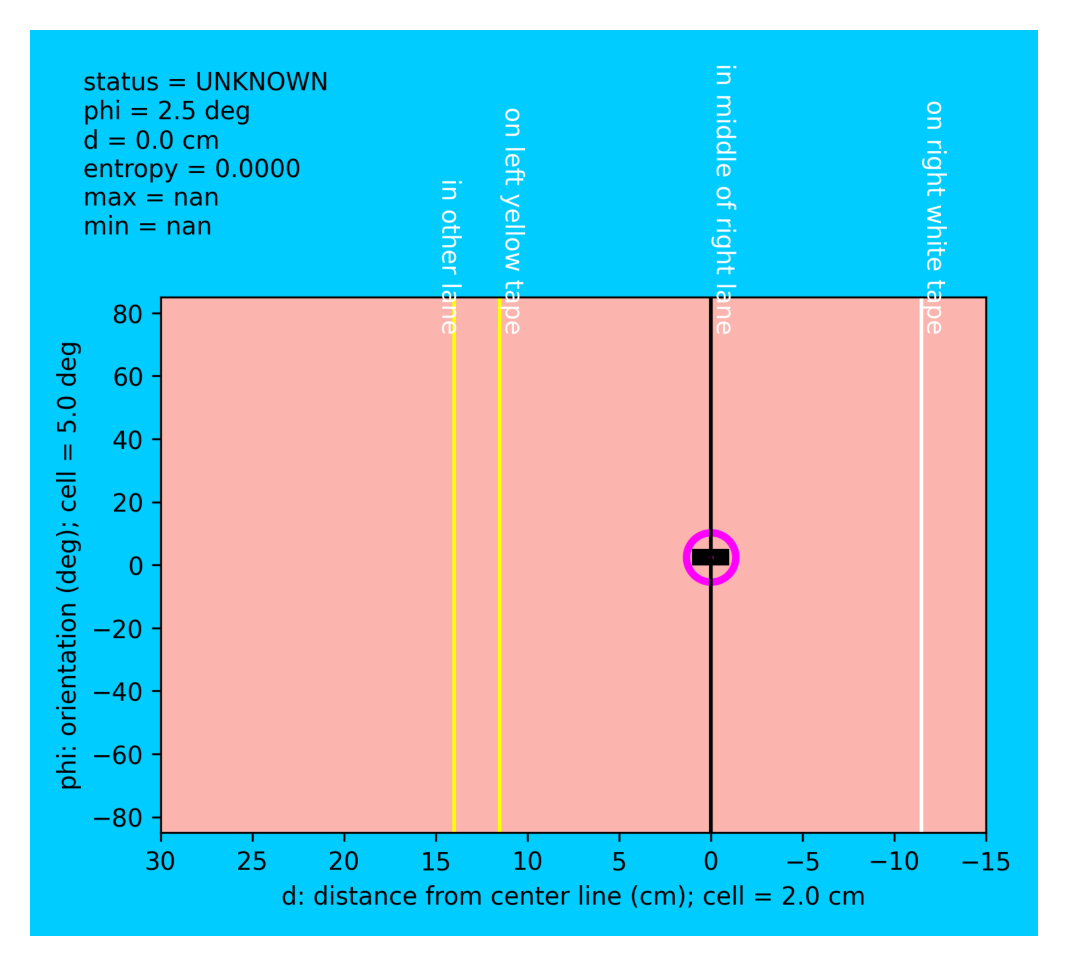

In [3]:
%matplotlib inline
matplotlib.rc("figure", dpi=300)

# create simple observation
run_filter(0, 0)

# plot belief
bgr = plot_belief(filter, dpi=300)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(rgb)

In [4]:
def _update_plot(_ls, _rot):
    # create simple observation
    stime = time.time()
    run_filter(_ls, _rot)
    print(f"Filter updated in {(time.time() - stime) * 1000:.3f}ms")
    # plot belief
    bgr = plot_belief(filter, dpi=300)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    # show image
    plt.axis('off')
    plt.imshow(rgb)

def on_change(x: float, y: float):
    _update_plot(x, np.deg2rad(y))

interact(
    on_change, 
    # lateral shift bar
    x=widgets.FloatSlider(min=-0.3, max=0.15, step=0.01, value=0, continuous_update=False),
    # rotation bar
    y=widgets.FloatSlider(min=-80, max=80, step=5, value=0, continuous_update=False)
)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=0.15, min=-0.3, ste…

<function __main__.on_change(x: float, y: float)>